# Introduction to Data Science

## Project: Implementation of Machine Learning Model to Predict Heart Failure Disease

This Jupyter notebook is used as part of the project assignment of the Introduction to Data Science course which deals with the  Implementation of Machine Learning Model to Predict Heart Failure Disease paper by Fahd Saleh Alotaibi. Original paper referenced in the project can be accessed via this [source](https://pdfs.semanticscholar.org/a74f/d8c51251e8c6126a1527e545bd78860a10f9.pdf). This project closely follows the paper's structure with addition of data preprocessing and description part as well as ethics based topics so its chapters will be organized in the chronological fashion respecting chapters defined in the paper as follows:
1. [Exploratory Data Analysis](#1)
2. [Data Preprocessing](#2)
3. [ML Classifiers for Heart Disease Prediction](#3)
4. [Model Performances and Comparisons](#4)
5. [Discussion](#5)

First part of the project explains the data overview, number of attributes and description of each attribute as well as showing the data preprocessing steps applied in this study. Second part of the project deals with presenting the experiment design, implementation, and performances of the classifiers respectively.

In [1]:
# pip install -U feature-engine
# pip install pydotplus
# pip install graphviz

Following cell presents every module used in this project (since the project's structure may be refined some time later there is possibility that some of those won't be used anymore). If there is some dependecy which is not satisfied be aware that while uncommenting and running lines in the cell above may resolve some of the problems there is a possiblity that some of the dependecy requirements will still not be satisfied so be sure to check [pip](https://pip.pypa.io/en/stable/) official page.  

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from feature_engine.discretisation import EqualWidthDiscretiser
from math import sqrt, log
from sklearn import metrics, tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, plot_confusion_matrix, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from statistics import mean, median, stdev

from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

## <a id="1"></a>1. Exploratory Data Analysis

This project aims to replicate approaches described in the paper dealing with the improvement of the HF prediction accuracy using [UCI heart disease dataset](https://www.kaggle.com/fedesoriano/heart-failure-prediction?select=heart.csv). For this, multiple machine learning approaches are used to understand the data and predict the HF chances in a medical database.

In [3]:
heart = pd.read_csv('../dataset/heart_extended.csv')
heart.shape

(918, 12)

There are total of 918 records in the UCI heart disease dataset consisting of 12 features - 11 independent decision features and 1 target value (heart disease).

In [4]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
heart.columns.values

array(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
       'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak',
       'ST_Slope', 'HeartDisease'], dtype=object)

Variables explanation:
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [6]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In the previous table it is possible to see some statistical measurements for numerical variables present in the dataset. Specifically, each row represents one measurement such as `count` (total number of records), `mean` (average value), `std` (standard deviation), `min` (minimal value), `25%` (25th quantile), `50%` (median value), `75%` (75th quantile) and `max` (maximal value). It is visible from the given values that `Cholesterol`, `MaxHR` and `Oldpeak` have maximum value much higher than the 75th quantile which could be indicator for potential outliers which will be presented in more details later. Also, minimum value of the `Oldpeak` attribute seems to be negative when proposed interval is $[0, 6.2]$ which will also be discussed with more details later. Other numerical attributes seems fine for now

### 1.1 Monotonous Attributes

Let's check if there are monotonous attributes, i.e. attributes whose value grows uniformly.

In [7]:
heart.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

The `nunique` function counts unique values per column and can serve as a good indicator of monotonous attributes. In this case, the candidates for the monotone attribute are `Cholesterol` and `MaxHR` because there is a fair share of unique values there - but then these are also numerical variables so we would expect that number to be higher so we will consider these variables to undergo some preprocessing in the next steps.

Since classification algorithms implemented in the `sklearn` module work exclusively with numerical values, every attempt of making a classification using the current version of the data will result in error. Let's see what values are numerical.

In [8]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


It seems that variables `Sex`, `ChestPainType`, `RestingECG`, `ExerciseAngina` and `ST_Slope` are the ones whose values are expressed in textual form so these variables will have to undergo some kind of transformation to numerical values since we want to work with models implemented in the `sklearn` module.

### 1.2 Missings Values

Missing data (or missing values) is defined as the data value that is not stored (usually `NaN`) for a variable in the observation of interest. The problem of missing data is relatively common in almost all research and can have a significant effect on the conclusions that can be drawn from the data so it is important to detect these kind of values and refine them appropriately.

In [9]:
heart.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

The mitigating circumstance of the data we have at our disposal seems to be the fact that there is no missing data for any of the variables, so we will not deal with this further in the part which deals with data preprocessing.

### 1.3 Outliers

An outlier is an observation that lies an abnormal distance from other values in a random sample from a population. These points are often referred to as outliers. Examination of the data for unusual observations that are far removed from the mass of data usually consists of calculating mean and median values as well as z-score and drawing a box plot.

In [10]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Based on this table, the candidates for the outliers are `Cholesterol`, `MaxHR` and `OldPeak`. `Oldpeak` attribute is defining the patient’s depression status. It is assigned as different real number values falls between 0 and 6.2. Since minimum value for the `Oldpeak` variable in the dataset is -2.6, it is obvious that there some kind of error has ocurred in the data so we will preprocess the `Oldpeak` values in the following chapter.

Since the values of the `MaxHR` variable are within the proposed ones, our suspicion of outliers was not justified, so this variable does not require additional preprocessing. Finally, maximal value for the `Cholesterol` variable seems too high s we will analyze this variable in more details.

In [11]:
print('Cholesterol > 100: ', (heart.Cholesterol > 100).sum())
print('Cholesterol > 200: ', (heart.Cholesterol > 200).sum())
print('Cholesterol > 300: ', (heart.Cholesterol > 300).sum())
print('Cholesterol > 400: ', (heart.Cholesterol > 400).sum())
print('Cholesterol > 500: ', (heart.Cholesterol > 500).sum())
print('Cholesterol > 600: ', (heart.Cholesterol > 600).sum())

Cholesterol > 100:  743
Cholesterol > 200:  596
Cholesterol > 300:  103
Cholesterol > 400:  13
Cholesterol > 500:  4
Cholesterol > 600:  1


In [12]:
heart.loc[heart.Cholesterol > 400, 'Cholesterol']

28     468
30     518
69     412
76     529
103    466
149    603
182    404
250    491
496    458
616    564
624    407
667    417
796    409
Name: Cholesterol, dtype: int64

These records are very different from the other records and can be considered as outliers. Visualizations are a good way to detect outliers, and they will be discussed in more detail in the next chapter. For now, we will not do anything about it, but we will be aware of these facts when modeling. 

### 1.4 Data Visualization

In this chapter we will dig deeper into data exploration as we want to find more convincing evidences of potential outliers and data values which were affected by some kind of error. For the beginning, histograms will be plotted for numerical values as well as pie charts for categorical ones.

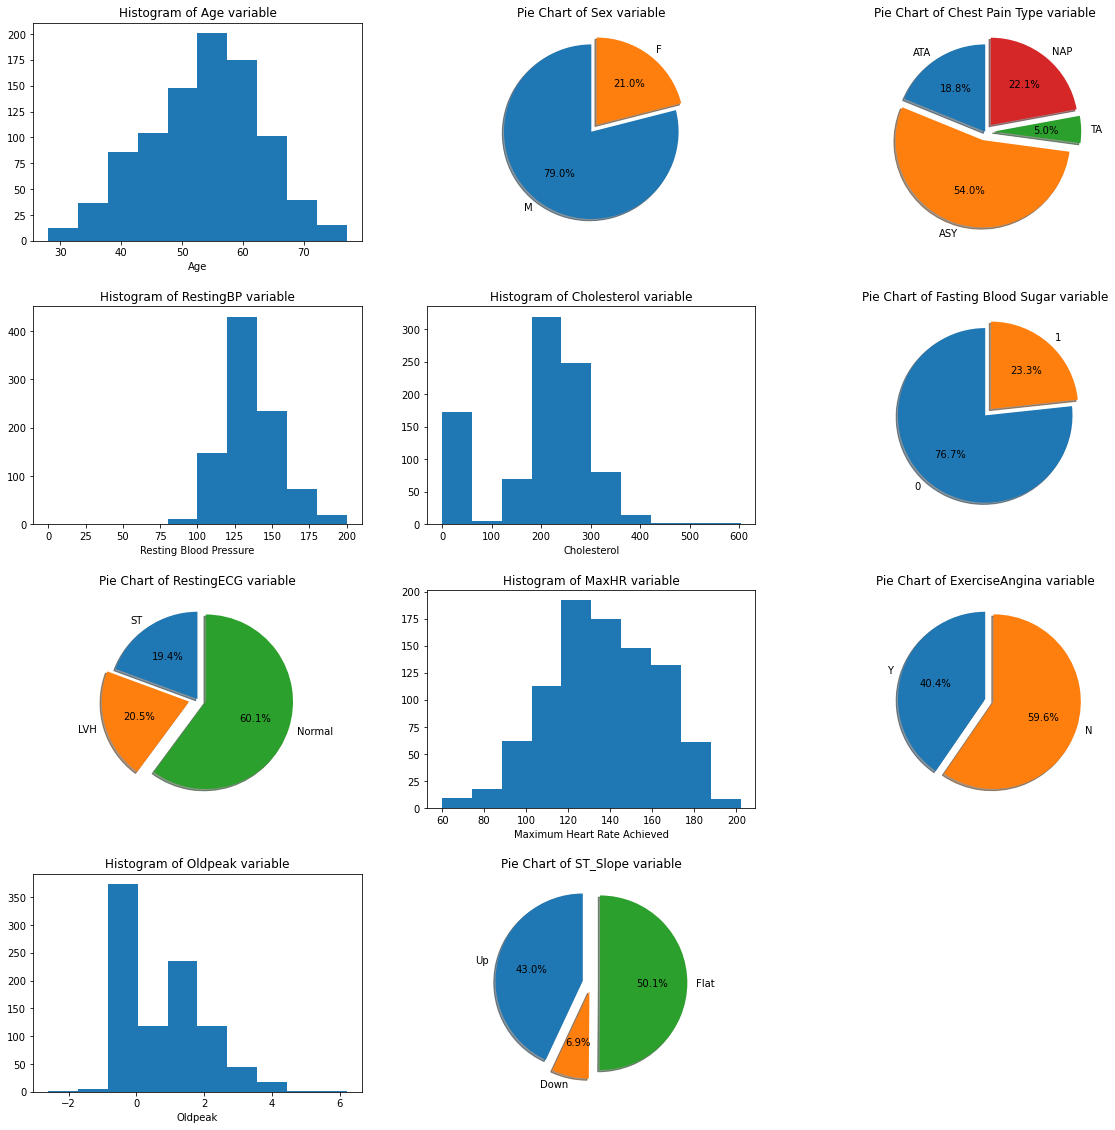

In [13]:
fig, ax = plt.subplots(4,3, figsize=(20,15))
plt.subplots_adjust(top = 1.00, bottom=0.01, hspace=0.3, wspace=0.2)

age = heart.Age.tolist()
ax[0,0].hist(age, bins=round(log(len(age), 2)))
ax[0,0].set_xlabel('Age')
ax[0,0].title.set_text('Histogram of Age variable')

sex = heart.Sex.tolist()
ax[0,1].pie([sex.count(label) for label in set(sex)], explode=(0, 0.1), labels=set(sex), 
                        autopct='%1.1f%%', shadow=True, startangle=90)
ax[0,1].title.set_text('Pie Chart of Sex variable')

cpt = heart.ChestPainType.tolist()
ax[0,2].pie([cpt.count(label) for label in set(cpt)], explode=(0, 0.1, 0.1, 0.1), labels=set(cpt),
                       autopct='%1.1f%%', shadow=True, startangle=90)
ax[0,2].title.set_text('Pie Chart of Chest Pain Type variable')

rbp = heart.RestingBP.tolist()
ax[1,0].hist(rbp, bins=round(log(len(rbp), 2)))
ax[1,0].set_xlabel('Resting Blood Pressure')
ax[1,0].title.set_text('Histogram of RestingBP variable')

chol = heart.Cholesterol.tolist()
ax[1,1].hist(chol, bins=round(log(len(chol), 2)))
ax[1,1].set_xlabel('Cholesterol')
ax[1,1].title.set_text('Histogram of Cholesterol variable')

fbs = heart.FastingBS.tolist()
ax[1,2].pie([fbs.count(label) for label in set(fbs)], explode=(0, 0.1), labels=set(fbs),
                       autopct='%1.1f%%', shadow=True, startangle=90)
ax[1,2].title.set_text('Pie Chart of Fasting Blood Sugar variable')

recg = heart.RestingECG.tolist()
ax[2,0].pie([recg.count(label) for label in set(recg)], explode=(0, 0.1, 0.1), labels=set(recg),
                       autopct='%1.1f%%', shadow=True, startangle=90)
ax[2,0].title.set_text('Pie Chart of RestingECG variable')

maxhr = heart.MaxHR.tolist()
ax[2,1].hist(maxhr, bins=round(log(len(maxhr), 2)))
ax[2,1].set_xlabel('Maximum Heart Rate Achieved')
ax[2,1].title.set_text('Histogram of MaxHR variable')

eang = heart.ExerciseAngina.tolist()
ax[2,2].pie([eang.count(label) for label in set(eang)], explode=(0, 0.1), labels=set(eang),
                       autopct='%1.1f%%', shadow=True, startangle=90)
ax[2,2].title.set_text('Pie Chart of ExerciseAngina variable')

opeak = heart.Oldpeak.tolist()
ax[3,0].hist(opeak, bins=round(log(len(opeak), 2)))
ax[3,0].set_xlabel('Oldpeak')
ax[3,0].title.set_text('Histogram of Oldpeak variable')

slope = heart.ST_Slope.tolist()
ax[3,1].pie([slope.count(label) for label in set(slope)], explode=(0.1, 0.1, 0.1), labels=set(slope),
                       autopct='%1.1f%%', shadow=True, startangle=90)
ax[3,1].title.set_text('Pie Chart of ST_Slope variable')

fig.delaxes(ax[3][2])

One more time, it is visible from the `Histogram of Cholesterol variable` that the shape of the histogram is heavily skeewed. What is the most worrying is the first column of the histogram in which a quite share of values is located, so in the following cells we will analyze this column of the graph in more detail and, if necessary, pre-process the data.

A box and whisker plot — also called a box plot — displays the five-number summary of a set of data. The five-number summary is the minimum, first quartile, median, third quartile, and maximum. In a box plot, we draw a box from the first quartile to the third quartile as this can help graphically demonstrating variables whose maximum and minumum values significantnly differ from the rest.

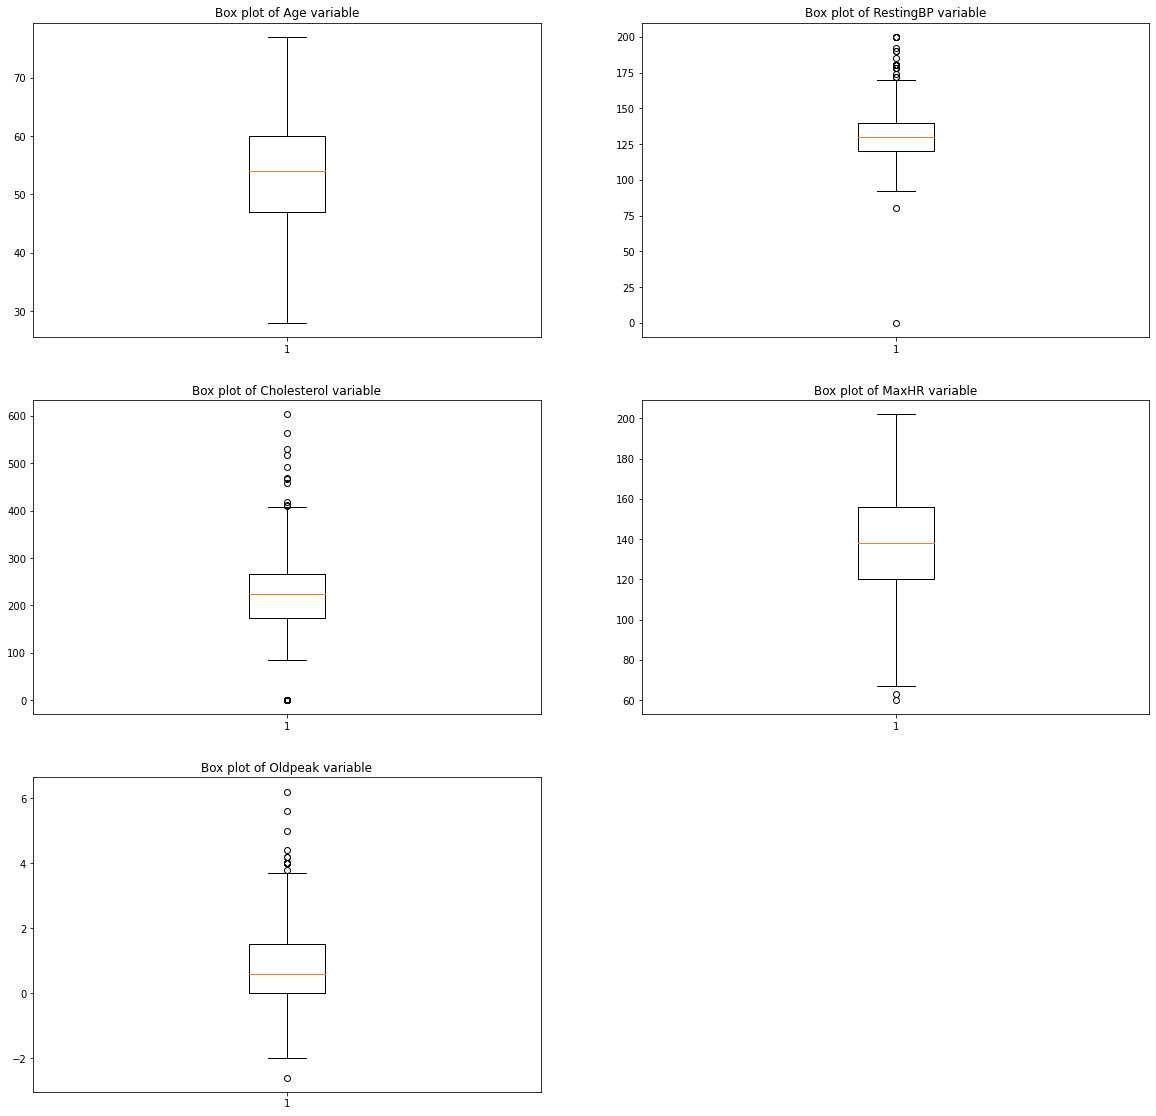

In [14]:
fig, ax = plt.subplots(3,2, figsize=(20,15))
plt.subplots_adjust(top = 1.00, bottom=0.01, hspace=0.2, wspace=0.2)

age = heart['Age'].tolist()
ax[0,0].boxplot(age)
ax[0,0].title.set_text('Box plot of Age variable')

rbp = heart['RestingBP'].tolist()
ax[0,1].boxplot(rbp)
ax[0,1].title.set_text('Box plot of RestingBP variable')

chol = heart['Cholesterol'].tolist()
ax[1,0].boxplot(chol)
ax[1,0].title.set_text('Box plot of Cholesterol variable')

maxhr = heart['MaxHR'].tolist()
ax[1,1].boxplot(maxhr)
ax[1,1].title.set_text('Box plot of MaxHR variable')

opeak = heart['Oldpeak'].tolist()

ax[2,0].boxplot(opeak)
ax[2,0].title.set_text('Box plot of Oldpeak variable')

fig.delaxes(ax[2][1])

At this point it is visible that our concerns were justified. It seems that quite share of records have `Cholesterol` variable set to $0$ which is expressed in $mm/dl$ when the normal value is $125$ $mm/dl$ which makes no sense and should undergo some kind of preprocessing. Furthermore, it is visible that there are some negative values in the `Oldpeak` variable which should be set to $0$ (minimum value) and this will also be adjusted in the following chapter. 

## <a id="2"></a>2. Data Preprocessing

Since the variables `Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `Excercise`, `ExcerciseAngina` and `ST_Slope` are expressed in textual form (for example, variable `ChestPainType` takes on values `TA`, `ATA`, `NAP` and `ASY`). Given the earlier remark that the `sklearn` package works exclusively with numerical values, it is necessary to convert such data into numerical values before starting to work with models. More details about the way of converting textual data from the heart disease dataset to numerical values can be studied from the original [paper](https://pdfs.semanticscholar.org/a74f/d8c51251e8c6126a1527e545bd78860a10f9.pdf).

In [15]:
sex_mapping = {'F': 0, 'M': 1}
heart.Sex = [sex_mapping[sex] for sex in heart.Sex]

cpt_mapping = {'TA': 0, 'ATA': 1, 'NAP': 2, 'ASY': 3}
heart.ChestPainType = [cpt_mapping[cpt] for cpt in heart.ChestPainType]

recg_mapping = {'Normal': 0, 'ST': 1, 'LVH': 2}
heart.RestingECG = [recg_mapping[recg] for recg in heart.RestingECG]

eang_mapping = {'N': 0, 'Y': 1}
heart.ExerciseAngina = [eang_mapping[eang] for eang in heart.ExerciseAngina]

slope_mapping = {'Up': 1, 'Flat': 2, 'Down': 3}
heart.ST_Slope = [slope_mapping[slope] for slope in heart.ST_Slope]

Table bellow presents converted dataset where it is clearly visible that variables `Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `Excercise`, `ExcerciseAngina` and `ST_Slope` now all have numerical values.

In [16]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,0,172,0,0.0,1,0
1,49,0,2,160,180,0,0,156,0,1.0,2,1
2,37,1,1,130,283,0,1,98,0,0.0,1,0
3,48,0,3,138,214,0,0,108,1,1.5,2,1
4,54,1,2,150,195,0,0,122,0,0.0,1,0


In [17]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


Now, let's see what is possible to do with `Cholesterol` variable. As stated earlier, we noticed that large share of values are concentrated close to the minimal value which causes the skewness of the histogram plot. Let's calculate the number of records whose `Cholesterol` attribute value is less than $100$. 

In [18]:
print(f'Cholesterol < 100: {(heart.Cholesterol < 100).sum()}')
print(f'Cholesterol = 0: {(heart.Cholesterol == 0).sum()}')

heart.describe()

Cholesterol < 100: 173
Cholesterol = 0: 172


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,2.251634,132.396514,198.799564,0.233115,0.603486,136.809368,0.404139,0.887364,1.638344,0.553377
std,9.432617,0.407701,0.931031,18.514154,109.384145,0.423046,0.805968,25.460334,0.490992,1.066570,0.607056,0.497414
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000
25%,47.000000,1.000000,2.000000,120.000000,173.250000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,3.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,3.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


It is intereseting to see that out of $173$ values which are less than $100$, $172$ are equal to $0$ which produces visible difference between mean and median for `Cholesterol` variable. To make things right, we will convert each record whose `Cholesterol` attribute value is set to $0$ by replacing that value with the median, those records whose `Cholesterol` attribute value differs from $0$ will not be affected. Median value is chosen because it is not affected by $0$ values as much as mean.

In [19]:
median_chol = median(heart.Cholesterol)
heart.Cholesterol = [median_chol if value == 0 else value for value in heart.Cholesterol.tolist()]

In [20]:
heart.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,2.251634,132.396514,240.581699,0.233115,0.603486,136.809368,0.404139,0.887364,1.638344,0.553377
std,9.432617,0.407701,0.931031,18.514154,53.982967,0.423046,0.805968,25.460334,0.490992,1.066570,0.607056,0.497414
min,28.000000,0.000000,0.000000,0.000000,85.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000
25%,47.000000,1.000000,2.000000,120.000000,214.000000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,3.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,3.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


Another irregularity which was detected was the fact that there are some records whose `Oldpeak` attribute value is negative when in the dataset description allowed interval is $[0, 6.2]$. This can be easily proved by looking at the table above - reading for the minimal value `min` of `Oldpeak` attribute shows that it is equal to $-2.6$.

In [21]:
print(f'Number of negative values in Oldpeak: {(heart.Oldpeak < 0).sum()}')

Number of negative values in Oldpeak: 13


We will replace every negative value detected in the `Oldpeak` column with the value `0` so that every value of the `Oldpeak` variable is inside the proposed interval. 

In [22]:
heart.Oldpeak = [value if value >= 0 else 0 for value in heart.Oldpeak]

print(f'Number of negative values in Oldpeak: {(heart.Oldpeak < 0).sum()}')
heart.describe()

Number of negative values in Oldpeak: 0


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,2.251634,132.396514,240.581699,0.233115,0.603486,136.809368,0.404139,0.901307,1.638344,0.553377
std,9.432617,0.407701,0.931031,18.514154,53.982967,0.423046,0.805968,25.460334,0.490992,1.045100,0.607056,0.497414
min,28.000000,0.000000,0.000000,0.000000,85.000000,0.000000,0.000000,60.000000,0.000000,0.000000,1.000000,0.000000
25%,47.000000,1.000000,2.000000,120.000000,214.000000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,3.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,3.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


After making the proposed changes to the `Cholesterol` and `Oldpeak` variables, it can be seen that the leftmost column in the `Cholesterol` histogram has been appropriately reduced and now the histogram more closely resembles the normal distribution. On the other hand, the Oldpeak variable no longer has negative values and is expected to record the highest number of values in the first column, which justifies the execution of the proposed procedures.

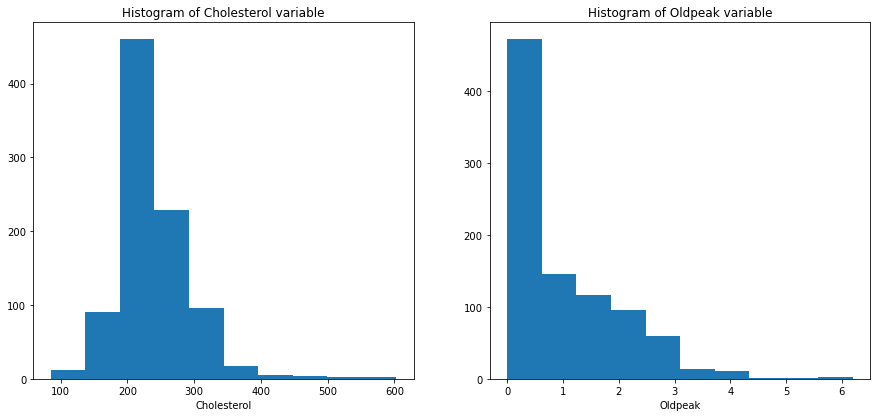

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.subplots_adjust(top = 1.00, bottom=0.01, hspace=0.3, wspace=0.2)

chol = heart.Cholesterol.tolist()
ax[0].hist(chol, bins=round(log(len(chol), 2)))
ax[0].set_xlabel('Cholesterol')
ax[0].title.set_text('Histogram of Cholesterol variable')

opeak = heart.Oldpeak.tolist()
ax[1].hist(opeak, bins=round(log(len(opeak), 2)))
ax[1].set_xlabel('Oldpeak')
ax[1].title.set_text('Histogram of Oldpeak variable')

There is only one more step to check before learning the machine learning model and it is detecting potential dependence between pairs of variables.

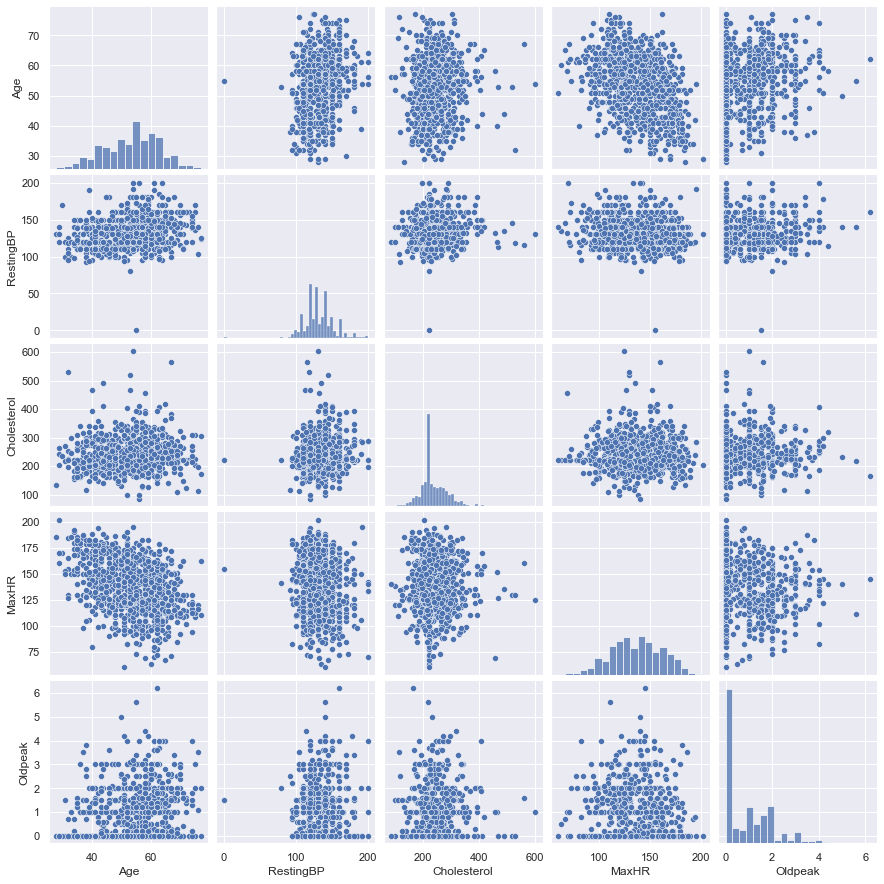

In [24]:
sns.set(rc={'figure.figsize':(25,15)})
sns.pairplot(heart.loc[:,['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']])
plt.show()

It does not seem as any pair of variables is mutually dependent or in any kind of correlation for that matter. Consequently, we will not omit any variable as these set of variables seems to be suitable for training models which will yield satisfying performance on the test dataset.

## <a id="3"></a>3. ML Classifiers for Heart Disease Prediction

Main idea behind this project is to put stress on how helpful machine learning approaches are to predict the heart disease using medical data. This section describes the comprehensive overview on the previous work accompanied to predict the heart disease in a patient using ML approaches. The idea of paper was to improve the previous work using the selected dataset and ML models, as described in the **VI. IMPLEMENTATION** section from the paper. The most commonly ML approaches found and used in this project are: Decision Tree, Naïve Bayes, Random Forest, Support Vector Machine, and Logistic Regression

In [25]:
# Separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
            heart.drop(['HeartDisease'], axis=1),
            heart['HeartDisease'], test_size=0.3, random_state=0)

Some approaches, such as Decision Tree, require the placement of continuous data in discretized categories - known as data bucketing. This procedure will be executed once and then used for appropriate models as necessary.

In [26]:
# kontinuirani: Age, RestingBP, Cholesterol, MaxHR, Oldpack

discretizer = EqualWidthDiscretiser(bins=10, variables = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'])

discretizer.fit(X_train)

X_tr = discretizer.transform(X_train)
X_te = discretizer.transform(X_test)

### 3.1 Decision Tree

In [27]:
# Create Decision Tree classifer object
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
dtc = dtc.fit(X_tr, y_train)

#Predict the response for test dataset
y_pred_dtc = dtc.predict(X_te)

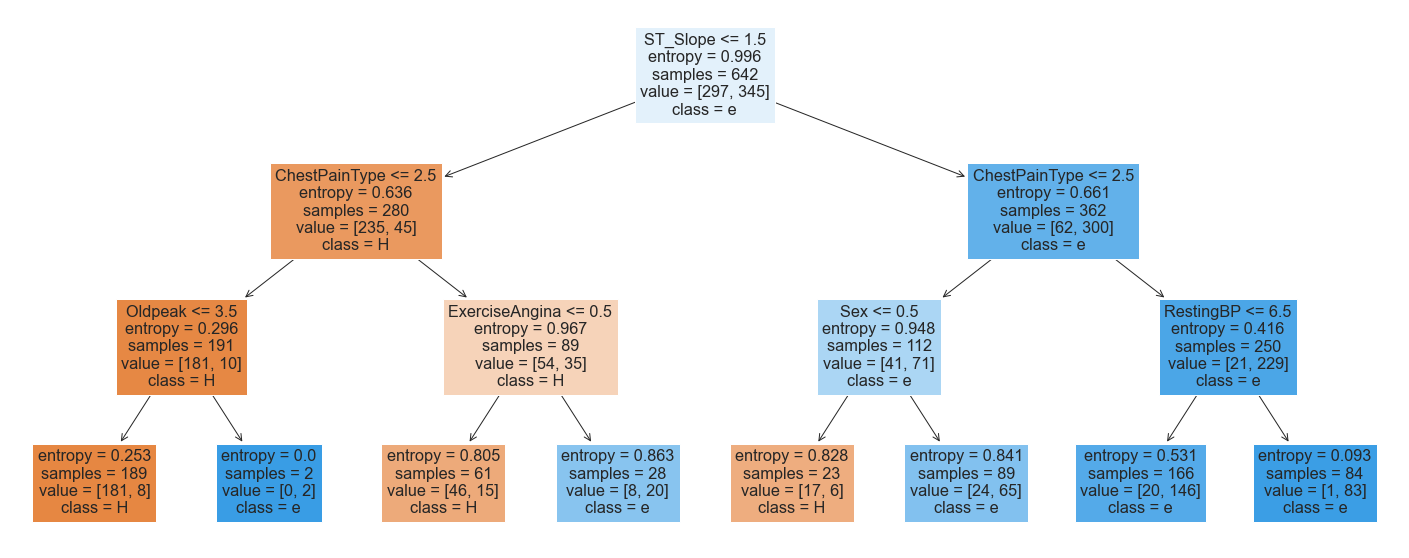

In [28]:
feature_names = heart.columns[:-1]
target_names = heart.columns[-1]

fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(dtc, 
                   feature_names=feature_names,  
                   class_names=target_names,
                   filled=True)

### 3.2 Naive Bayes


In [29]:
# Create a Gaussian Classifier
gnb = GaussianNB()

# Train the model using the training sets
gnb.fit(X_train, y_train)

# Predict the response for test dataset
y_pred_gnb = gnb.predict(X_test)

### 3.3 Random Forest


In [30]:
rfc = RandomForestClassifier()

parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]   
}

cv = GridSearchCV(rfc,parameters,cv=5)
cv.fit(X_tr, y_train)

print(f'Optimal parameters are: {cv.best_params_}')

Optimal parameters are: {'max_depth': 4, 'n_estimators': 100}


In [31]:
max_depth = cv.best_params_['max_depth']
n_estimators = cv.best_params_['n_estimators']

rfc = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)

rfc = rfc.fit(X_tr, y_train)

y_pred_rfc = rfc.predict(X_te)

### 3.4 Logistic Regression


In [32]:
lr = LogisticRegression(max_iter=10000)
lr = lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

### 3.5 SVM

In [33]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

## <a id="4"></a>4. Model Performances and Comparisons

The model performance in the form of confusion matrix is displayed in chapter **4.1 Confussion Matrix**. A confusion matrix is a table used for describing the performance of a classifier that when executed on given test data where the `True` values are considered known data values shows the number of true positive, true negative, false positive and false negative values. In this table, the True Class (1) means the known values for the class category (1); the patients having chances
of heart failure. On the other side, True Class (0) denotes the known values for class category (0); the patients showing
healthy sign. Other performance metrics such as accurracy, recall, precision and F1-score are display in the following chapters. 

### 4.1 Confussion Matrix

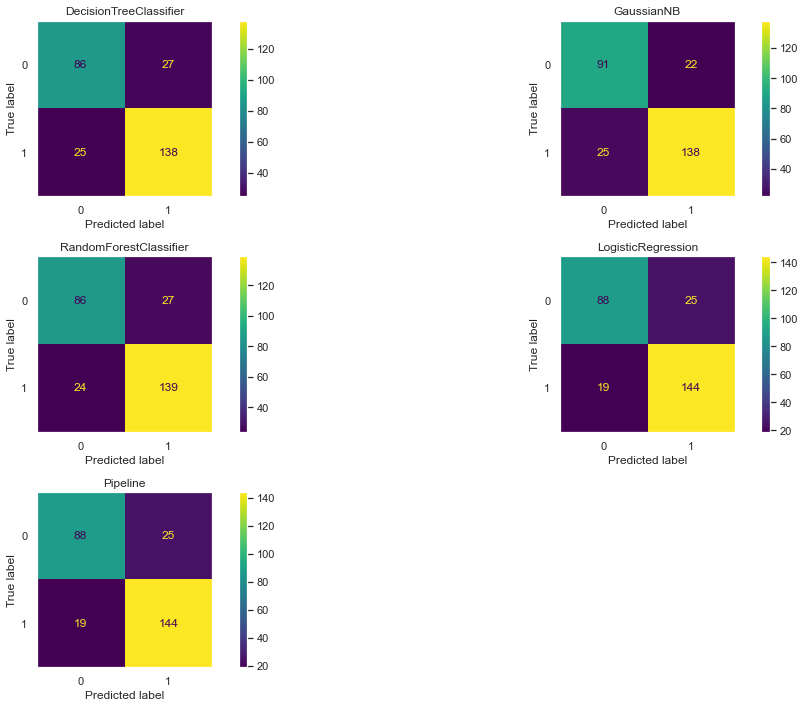

In [34]:
classifiers = [dtc, gnb, rfc, lr, svm]
    
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax)
    ax.grid(False)
    ax.title.set_text(type(cls).__name__)

fig.delaxes(axes[2][1])   
plt.tight_layout()  
plt.show()

### 4.2 Accuracy

Accuracy is one of the metrics for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right. Formally, accuracy has the following definition: 

$$ Accuracy = \frac{Number\space of\space correct\space predictions}{Total\space number\space of\space predictions} $$


For binary classification, accuracy can also be calculated in terms of positives and negatives as follows:

$$ Accuracy = \frac{TP+TN}{TP+TN+FP+FN} $$

where $TP$ = True Positives, $TN$ = True Negatives, $FP$ = False Positives, and $FN$ = False Negatives.

In [35]:
print("Accuracy (Decision Tree):", metrics.accuracy_score(y_test, y_pred_dtc))
print("Accuracy (Naive Bayes):", metrics.accuracy_score(y_test, y_pred_gnb))
print("Accuracy (Random Forest):", metrics.accuracy_score(y_test, y_pred_rfc))
print("Accuracy (Logistic Regression):", metrics.accuracy_score(y_test, y_pred_lr))
print("Accuracy (SVM):", metrics.accuracy_score(y_test, y_pred_svm))

Accuracy (Decision Tree): 0.8152173913043478
Accuracy (Naive Bayes): 0.8297101449275363
Accuracy (Random Forest): 0.822463768115942
Accuracy (Logistic Regression): 0.8405797101449275
Accuracy (SVM): 0.8405797101449275


### 4.3 Recall

Recall attempts to answer the following question:

``What proportion of actual positives was identified correctly?``

Mathematically, recall is defined as follows:
    $$ Recall = \frac{TP}{TP+FN} $$
    
where $TP$ = True Positives and $FN$ = False Negatives.

In [36]:
print("Recall (Decision Tree):", recall_score(y_test, y_pred_dtc))
print("Recall (Naive Bayes):", recall_score(y_test, y_pred_gnb))
print("Recall (Random Forest):", recall_score(y_test, y_pred_rfc))
print("Recall (Logistic Regression):", recall_score(y_test, y_pred_lr))
print("Recall (SVM):", recall_score(y_test, y_pred_svm))

Recall (Decision Tree): 0.852760736196319
Recall (Naive Bayes): 0.8466257668711656
Recall (Random Forest): 0.8588957055214724
Recall (Logistic Regression): 0.8834355828220859
Recall (SVM): 0.8834355828220859


### 4.4 Precision

Precision attempts to answer the following question:

``What proportion of positive identifications was actually correct?``

Precision is defined as follows:
    $$ Precision = \frac{TP}{TP+FP}$$
where $TP$ = True Positives and $FP$ = False Positives.

In [37]:
print("Precision (Decision Tree):", precision_score(y_test, y_pred_dtc))
print("Precision (Naive Bayes):", precision_score(y_test, y_pred_gnb))
print("Precision (Random Forest):", precision_score(y_test, y_pred_rfc))
print("Precision (Logistic Regression):", precision_score(y_test, y_pred_lr))
print("Precision (SVM): ", precision_score(y_test, y_pred_svm))

Precision (Decision Tree): 0.8373493975903614
Precision (Naive Bayes): 0.8625
Precision (Random Forest): 0.8433734939759037
Precision (Logistic Regression): 0.8520710059171598
Precision (SVM):  0.8520710059171598


### 4.5 F1-score

The formula for the standard F1-score is the harmonic mean of the precision and recall. A perfect model has an F-score of 1.
F1-score is defined as follows:
    $$ F_1 = 2 \times \frac{precision \times recall}{precision + recall} $$
where $precision$ and $recall$ are defined as decribed previously.

In [38]:
print("F1 score (Decision Tree): ", f1_score(y_test, y_pred_dtc))
print("F1 score (Naive Bayes):", f1_score(y_test, y_pred_gnb))
print("F1 score (Random Forest):", f1_score(y_test, y_pred_rfc))
print("F1 score (Logistic Regression):", f1_score(y_test, y_pred_lr))
print("F1 score (SVM):", f1_score(y_test, y_pred_svm))

F1 score (Decision Tree):  0.8449848024316109
F1 score (Naive Bayes): 0.8544891640866874
F1 score (Random Forest): 0.8510638297872339
F1 score (Logistic Regression): 0.8674698795180722
F1 score (SVM): 0.8674698795180722


## <a id="5"></a>5. Discussion

The last part of the project deals with the formal side of the project and the paper it deals with, and answers the questions and problems defined in the following three points:
- what type of research was conducted in the article according to: purpose, source of information, time of implementation, method of collection and type of data used, degree of manipulation of variables, depth and type of conclusion
- what methods were used to collect data for the article,
- whether the data were collected and published according to the rules of research ethics.

### 5.1 Type of Research

The research conducted in the paper that this project deals with, divided by purpose, belongs to the applied research as it relies on the previously defined theory related to machine learning models and heart diseas analysis in order to create practical scientific knowledge.

According to the degree of manipulation of variables, this is an experimental study since is trying to change the value of an independent variable to identify its relationship with the dependent variable and thus predict future behavior (supervised machine learning).

Given the type of data used, for this type of research it is only possible to use data by quantitatively collecting and using mathematical, statistical and computer-aided tools to measure them in order to explain, predict or control a phenomenon with such measurable variables.

According to the time of implementation, this type of research is classified as synchronous research because it does not monitor the development of variables over time but uses those measured and/or collected at some point.

At the beginning of the research, a hypothesis was set up in which an attempt is made to improve the success of the current work of standard models of machine learning within their precision as opposed to the one used so far. However, the real validity of such a hypothesis was carried out on standard machine learning tasks as well as on two additional examples that showed that the hypothesis has a foothold in practice, so it is a hypothetical-deductive research.

According to depth, this type of research can be included in explanatory research as it provides additional information (how to optimize them) about the observed object, in this case random forests, and the application of their properties to a set of different problems and tasks.

Given the source of information, in this case the information is based on scientific literature and other documents compiled by another researchers and medical professionals and such is used to synthesize and supplement existing knowledge, so it is a secondary research.

Data for training and testing of various machine learning models from scientific work came as a combination of results from secondary (documented) sources and primary sources through field or laboratory research, so, according to the division of research according to data collection, it is a mixed research.

### 5.2 Data Collection Methods

This dataset was created by combining different datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes. The five datasets used for its curation are:

- Cleveland: 303 observations
- Hungarian: 294 observations
- Switzerland: 123 observations
- Long Beach VA: 200 observations
- Stalog (Heart) Data Set: 270 observations

Total: 1190 observations
Duplicated: 272 observations

``Final dataset: 918 observations``

Every dataset used can be found under the Index of heart disease datasets from UCI Machine Learning Repository on the following link: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

The original dataset version was collected by Tanvir Ahmad, Assia Munir, Sajjad Haider Bhatti, Muhammad Aftab, and Muhammad Ali Raza (Government College University, Faisalabad, Pakistan) and made available by them on FigShare under the Attribution 4.0 International (CC BY 4.0: freedom to share and adapt the material) copyright in July 2017.

The current version of the dataset was elaborated by Davide Chicco (Krembil Research Institute, Toronto, Canada) and donated to the University of California Irvine Machine Learning Repository under the same Attribution 4.0 International (CC BY 4.0) copyright in January 2020.

### 5.3 Reaserch Ethics

In accordance with research ethics, no one should suffer harm as a result of participating in research. The emphasis is on the possibility of damage of any kind and the likelihood of it occurring. Given that, according to the data in the description of the aforementioned datasets, data collection took place in accordance with the law, openly and fairly, without rigging the results and with a serious understanding of personal safety (personal identification numbers of patients were omitted from the dataset) - it is safe to assume that the data was collected and published in accordance with rules of research ethics.